In [1]:
library(reticulate)
use_condaenv(condaenv="pyr2", conda="/data8t_0/hms/anaconda3/bin/conda")
# umap<-import('umap')

In [3]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)
datasetName = "Intestine_Intestine_HCLFetalIntestine3"
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)

setwd("/stor/public/hcad/db_v1/Intestine_Intestine_HCLFetalIntestine3/")

In [3]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv"),h = T,sep='\t',row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


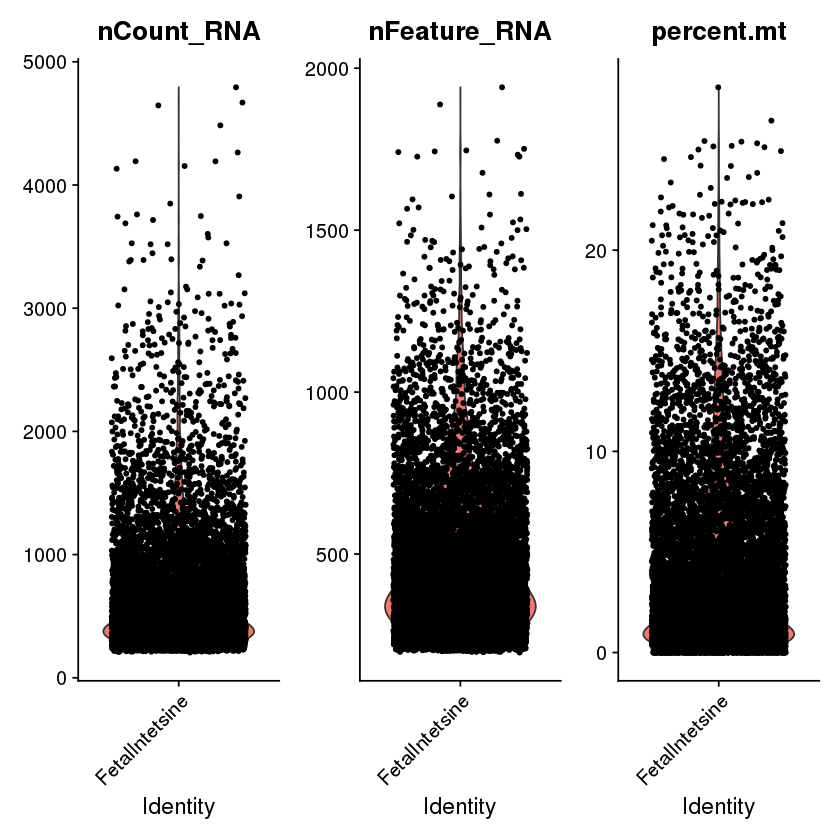

In [4]:
# Pre-processing
min.cells = 10
min.features = 200
nFeature_RNA_range = c(min.features, 1000)
percent.mt.thre = 1
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, min.features = min.features, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)

if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

# QC
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
VlnPlot(object = dataobj, features= c("nCount_RNA","nFeature_RNA","percent.mt"))

In [5]:
percent.mt.thre = 15
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)

In [6]:
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)

In [7]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)
suppressMessages(suppressWarnings(library(stringr)))
suppressMessages(suppressWarnings(library(dplyr)))

In [8]:
# *--------------------Load reference table--------------------*
print("=========Loading Reference Table=========")
ref_table_raw <- read.csv("/data8t_0/hms/workspace/HCA-d/Rtoolkit_GeneSymbolUniform/GeneSymbolRef_SelectAll_upd0731.csv", header=TRUE, na.strings=TRUE, stringsAsFactors=FALSE)
# print(dim(ref_table_raw))
print("Finished")
# *--------------------Load total gene list--------------------*
print("=========Processing Gene List=========")
total_gene_list_raw = read.table("/data8t_0/hms/workspace/HCA-d/Rtoolkit_GeneSymbolUniform/total_gene_list_43878.txt", 
                                 header=TRUE, sep='\t', fill=TRUE, stringsAsFactors=FALSE)
total_gene_list = total_gene_list_raw[,1]
# Seurat changes all "_" to "-".
total_gene_list <- str_replace(total_gene_list, "_", "-")
print("The length of gene list is: ")
print(length(total_gene_list))
print("Finished")
print("=========Processing Reference Table=========")
# Separate dataframe to previous and alias symbol sub-dataframe
# Remove duplicates and empty values
ref_table_raw <- ref_table_raw[,c("Approved.symbol","Alias.symbol","Previous.symbol")]
ref_table <- ref_table_raw[ref_table_raw[,"Previous.symbol"]!="" | ref_table_raw[,"Alias.symbol"]!="",]
# Seurat changes all "_" to "-".
ref_table$Previous.symbol <- str_replace(ref_table$Previous.symbol, "_", "-")
ref_table$Alias.symbol <- str_replace(ref_table$Alias.symbol, "_", "-")
ref_table$Approved.symbol <- str_replace(ref_table$Approved.symbol, "_", "-")
# print(dim(ref_table))
ref_table_prev <- unique(ref_table[,c("Approved.symbol","Previous.symbol")])
ref_table_prev <- ref_table_prev[ref_table_prev[,"Previous.symbol"]!="",]
ref_table_alia <- unique(ref_table[,c("Approved.symbol","Alias.symbol")])
ref_table_alia <- ref_table_alia[ref_table_alia[,"Alias.symbol"]!="",]
# print(dim(ref_table_prev))
# print(dim(ref_table_alia))
print("Finished")

# *--------------------Load query data--------------------*
print("=========Loading Query Data=========")
query_data <- as.data.frame(as.matrix(dataobj@assays$RNA@data))
query_gene_list <- rownames(dataobj)
print("The shape of query data is: ")
print(dim(query_data))
print("Print out first 5 genes in query data, in case something wrong happens in data loading: ")
print(query_gene_list[1:5])
print("Finished")

# *--------------------Perform gene name uniform--------------------*
print("=========Performing Gene Symbol Uniform=========")
print("Performing gene symbol uniform, this step may take several minutes")
gene_appearance_list <- data.frame(gene_name=total_gene_list, appearance=rep(FALSE, length(total_gene_list)))
outlier_gene_list <- c()

result_data <- query_data
result_data$genenames <- rownames(result_data)
report <- data.frame(Original.Name=character(), Modified.Name=character(), Status=character(), stringsAsFactors=FALSE)

for (i in c(1:length(query_gene_list))){
  gene_name <- query_gene_list[i]
  # Modify gene symbols, both "Alias symbol" and "Previous symbol" are used. 
  if(sum(ref_table_prev["Previous.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_prev["Previous.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
    
  else if(sum(ref_table_alia["Alias.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_alia["Alias.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
  
  # Gene name not found
  else{
    report[i,] <- c(gene_name, gene_name, "No Change")
    if(gene_name %in% total_gene_list){
      gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
    }
    else{
      outlier_gene_list <- c(outlier_gene_list, gene_name)
    }
  }
}
print("Finished")

# *--------------------Construct uniform output--------------------*
print("=========Building Output Matrix=========")
result_data_grouped <- result_data %>% group_by(genenames) %>% summarise_at(vars(-group_cols()), mean)
result_data_sub <- as.data.frame(result_data_grouped)[which(!result_data_grouped$genenames %in% outlier_gene_list),]
result_data_out <- subset(result_data_sub, select = -genenames )
rownames(result_data_out) <- result_data_sub$genenames
print("Shape of processed query data: ")
print(dim(result_data_out))

add_df <- data.frame(matrix(nrow=sum(gene_appearance_list$appearance==FALSE),ncol=dim(result_data)[2]-1, 0))
rownames(add_df) <- gene_appearance_list$gene_name[!gene_appearance_list$appearance]
colnames(add_df) <- colnames(result_data_out)

result_data_out <- rbind(result_data_out, add_df)
print("Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged.")
print(dim(result_data_out))
print("Finished")

[1] "=========Loading Reference Table========="
[1] "Finished"
[1] "=========Processing Gene List========="
[1] "The length of gene list is: "
[1] 43878
[1] "Finished"
[1] "=========Processing Reference Table========="
[1] "Finished"
[1] "=========Loading Query Data========="
[1] "The shape of query data is: "
[1] 14051  9027
[1] "Print out first 5 genes in query data, in case something wrong happens in data loading: "
[1] "A1CF"  "A2M"   "AAAS"  "AACS"  "AADAC"
[1] "Finished"
[1] "=========Performing Gene Symbol Uniform========="
[1] "Performing gene symbol uniform, this step may take several minutes"
[1] "Finished"
[1] "=========Building Output Matrix========="
[1] "Shape of processed query data: "
[1] 12909  9027
[1] "Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged."
[1] 43878  9027
[1] "Finished"


In [9]:
dataobj <- CreateSeuratObject(result_data_out,meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Warning message in CreateSeuratObject(result_data_out, meta.data = data.metadata):
“Some cells in meta.data not present in provided counts matrix.”
Centering and scaling data matrix



PC_ 1 
Positive:  FTL, FABP2, SERPINA1, RBP2, APOA1, SEPP1, RPS27, TTR, FTH1, APOC3 
	   FXYD3, NPC2, ID2, PLIN2, RPL10, S100A14, GSTA1, SMLR1, GLRX, RPS20 
	   CTSA, SAT1, SULT2A1, TM4SF20, RPL34, GSTA2, OAT, C4orf3, RPL27A, SLC7A7 
Negative:  TUBA1A, STMN2, GAP43, DPYSL3, UCHL1, PCP4, ETV1, MLLT11, VIP, PRPH 
	   ELAVL4, STMN1, MAP1B, NCAM1, RTN1, NEFL, TUBB2B, CHRNA3, NOS1, INA 
	   PGM2L1, BASP1, CADM1, L1CAM, LINC00682, VAT1L, HAND2, TAGLN3, KCTD12, STMN4 
PC_ 2 
Positive:  STMN2, GAP43, UCHL1, PCP4, VIP, ETV1, DPYSL3, PRPH, ELAVL4, TUBA1A 
	   MLLT11, L1CAM, INA, NEFL, NOS1, CHRNA3, RTN1, TUBB2B, LINC00682, MAP1B 
	   PGM2L1, HAND2, STMN4, TAGLN3, VAT1L, PHOX2A, NNAT, RET, GAL, SERPINA1 
Negative:  COL3A1, COL1A2, COL1A1, HLA-DRA, LGALS1, VIM, SRGN, CD74, AIF1, SPARC 
	   POSTN, DCN, TMSB4X, HLA-DRB1, RGS1, FSTL1, TYROBP, LUM, GPR183, CCL3 
	   HLA-DPA1, CXCL8, HLA-DPB1, MGP, CCL4, OGN, DNASE1L3, C1QA, HLA-DQB1, FCER1G 
PC_ 3 
Positive:  HLA-DRA, CD74, SRGN, HLA-DRB1, AIF1, CCL3,

png 
  2

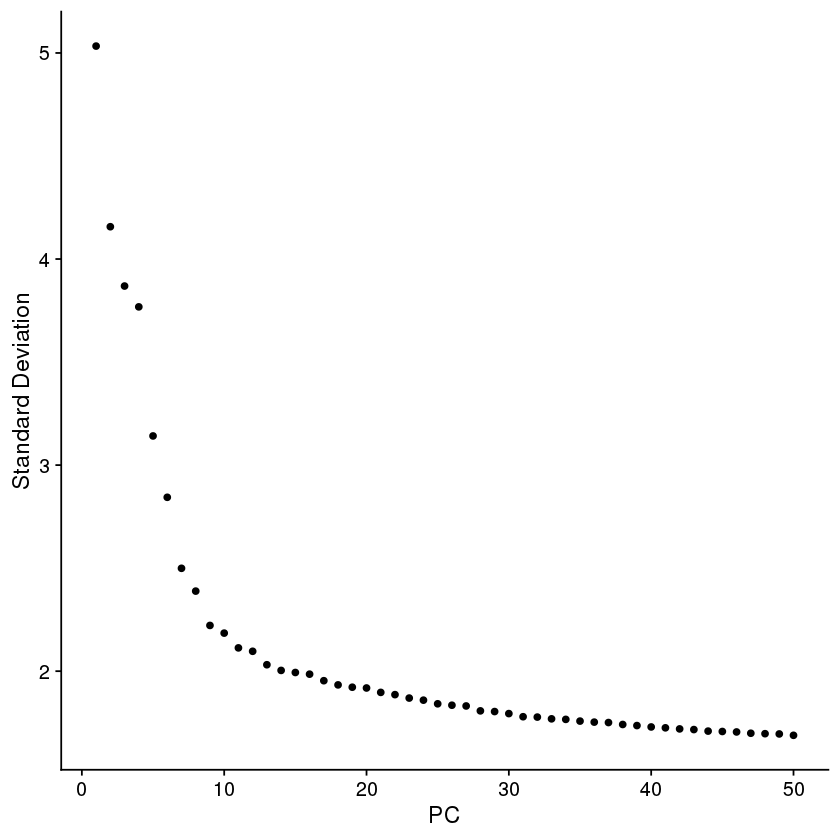

In [33]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj),npcs=50)
# Determine the ‘dimensionality’ of the dataset according to elbow plot
pdf(paste0(datasetName,"seurat.elbowplot.pdf"))
ElbowPlot(dataobj,ndim=50) 
dev.off()
ElbowPlot(dataobj,ndim=50) 

In [34]:
pcDim = 50 # set as 75 in this case 

# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)

Computing nearest neighbor graph

Computing SNN



In [42]:
dataobj <- FindClusters(dataobj, resolution = 0.79, n.start = 5)
randIndex(dataobj$cell_cluster,dataobj$seurat_clusters)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9027
Number of edges: 631367

Running Louvain algorithm...
Maximum modularity in 5 random starts: 0.7204
Number of communities: 15
Elapsed time: 1 seconds


1 singletons identified. 14 final clusters.



ARI 
0.2437548

In [43]:
rr <- RunUMAP(dataobj,dims=1:pcDim)

21:01:44 UMAP embedding parameters a = 0.9922 b = 1.112

21:01:44 Read 9027 rows and found 50 numeric columns

21:01:44 Using Annoy for neighbor search, n_neighbors = 30

21:01:44 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

21:01:47 Writing NN index file to temp file /tmp/RtmpjXcVzt/filec9743cbe2f21

21:01:47 Searching Annoy index using 1 thread, search_k = 3000

21:01:51 Annoy recall = 100%

21:01:51 Commencing smooth kNN distance calibration using 1 thread

21:01:52 Initializing from normalized Laplacian + noise

21:01:53 Commencing optimization for 500 epochs, with 446706 positive edges

21:02:28 Optimization finished



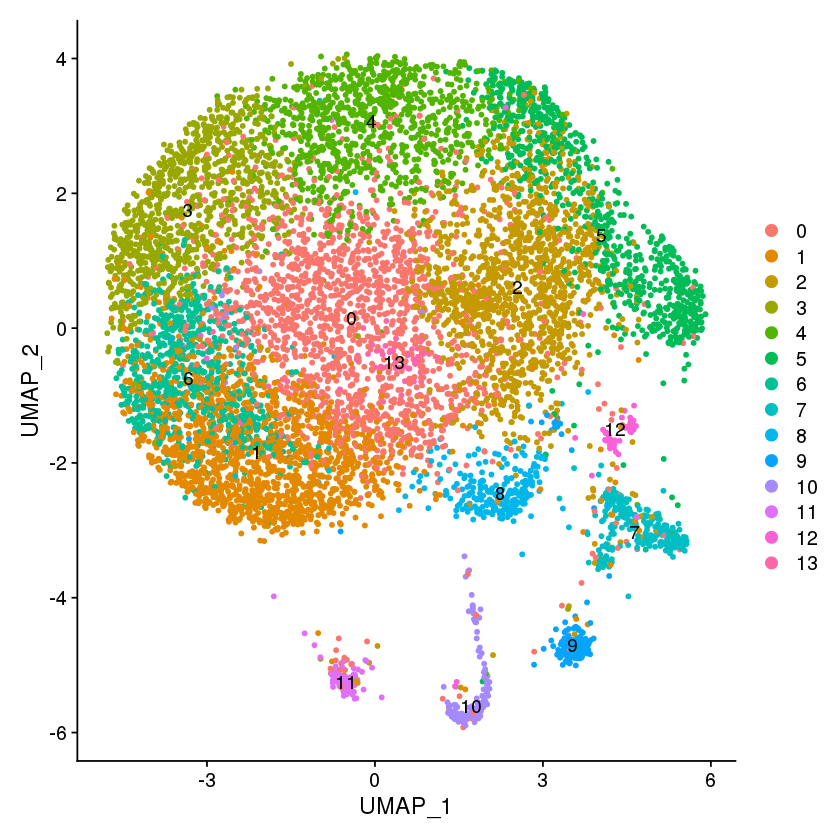

In [44]:
p_umap=DimPlot(rr,label = TRUE, pt.size=1)
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)
p_umap

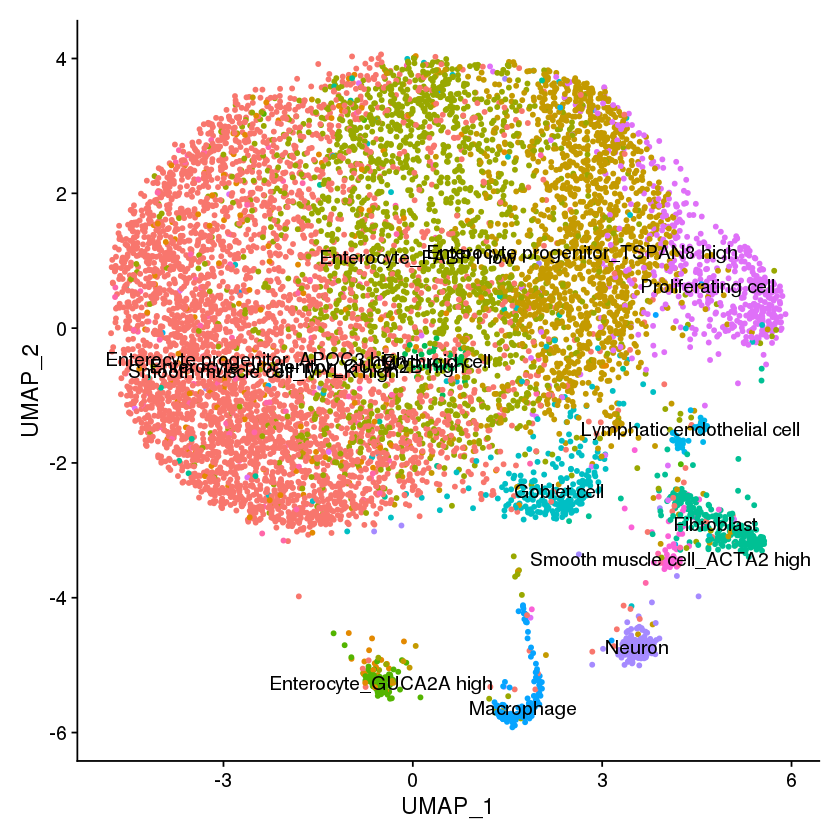

In [45]:
p_umap2 <- DimPlot(rr, reduction = "umap", label = T, group.by = "cell_cluster", pt.size=1)+NoLegend()
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)
p_umap2

In [5]:
new.cluster.ids <- c("Intestine-Epithelial tissue-Enterocyte-RIMBP2", 
                     "Intestine-Epithelial tissue-Enterocyte progenitor-APOC3", 
                     "Intestine-Epithelial tissue-Enterocyte progenitor-TSPAN8", 
                      "Intestine-Epithelial tissue-Enterocyte progenitor-APOC3", 
                     "Intestine-Epithelial tissue-Enterocyte-RIMBP2", 
                     "Intestine-Epithelial tissue-Proliferating T cell-UBE2C", 
                     "Intestine-Epithelial tissue-Enterocyte progenitor-APOC3",
                     "Intestine-Connective tissue-Fibroblast-LUM",
                    "Intestine-Epithelial tissue-Goblet cell-MUC2",
                     "Intestine-Nerve tissue-Neuron-STMN2",
                     'Intestine-Connective tissue-Macrophage-C1QA',
                     "Intestine-Epithelial tissue-Enterocyte-GUCA2A",
                    "Intestine-Epithelial tissue-Lymphatic endothelial cell-LYVE1",
                     'Intestine-Connective tissue-Erythrocyte-HBA1'
                    )

In [6]:
subset(dataobj.markers,cluster=='13')

ERROR: Error in subset(dataobj.markers, cluster == "13"): 找不到对象'dataobj.markers'


In [7]:
names(x = new.cluster.ids) <- levels(x = dataobj)
annodataobj <- RenameIdents(object = dataobj, new.cluster.ids)

In [63]:
rr2 <- RunUMAP(annodataobj,dims=1:pcDim)

21:23:03 UMAP embedding parameters a = 0.9922 b = 1.112

21:23:03 Read 9027 rows and found 50 numeric columns

21:23:03 Using Annoy for neighbor search, n_neighbors = 30

21:23:03 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

21:23:06 Writing NN index file to temp file /tmp/RtmpjXcVzt/filec9741a7d13ac

21:23:06 Searching Annoy index using 1 thread, search_k = 3000

21:23:10 Annoy recall = 100%

21:23:10 Commencing smooth kNN distance calibration using 1 thread

21:23:12 Initializing from normalized Laplacian + noise

21:23:12 Commencing optimization for 500 epochs, with 446706 positive edges

21:23:50 Optimization finished



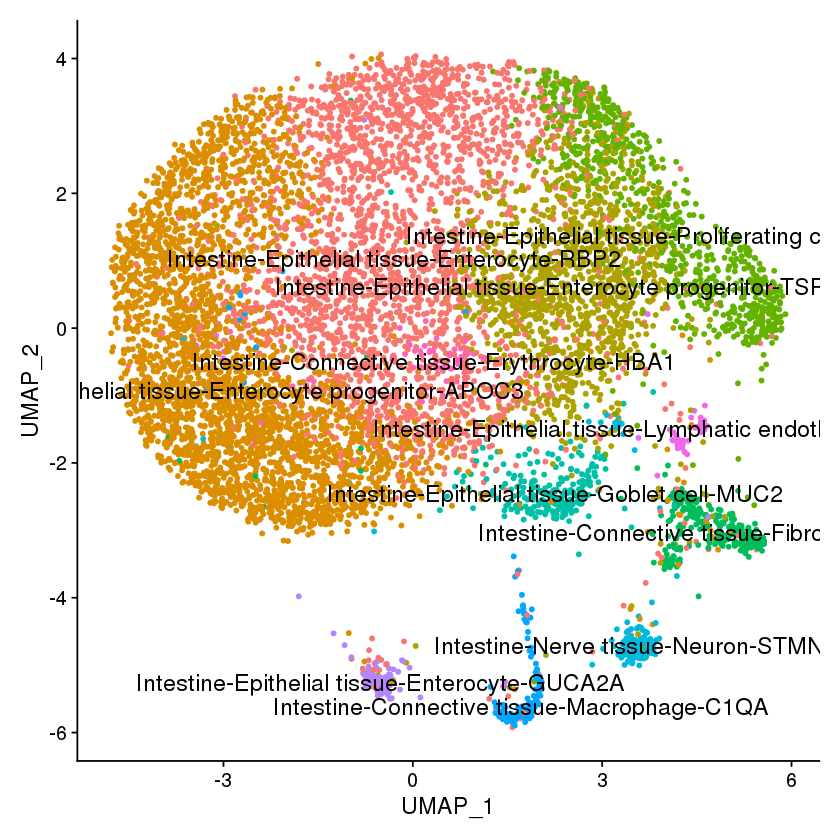

In [64]:
p_umap4 <- UMAPPlot(rr2,label = T, pt.size=1,label.size=5)+NoLegend()
# LabelClusters(plot = p_umap4, id = 'ident', color = 'white')
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap4, width = 25, height = 15)
p_umap4

In [46]:
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE,)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13



In [65]:
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)
# 
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [4]:
dataobj <- readRDS(paste0(datasetName,".seuratobj.rds"))

In [8]:
dataobj<-AddMetaData(dataobj, metadata =as.character(annodataobj@active.ident),col.name='hcad.label') 

write.table(cbind(colnames(dataobj), dataobj$hcad.label), file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = c('cell_ID','cell_cluster'))

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [13]:
dataobj.dbupload_v11 <- CreateSeuratObject(result_data_out)
# dataobj.dbupload_v1 <- NormalizeData(dataobj.dbupload_v1, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj.dbupload_v11[['orig.ident']] <- NULL
dataobj.dbupload_v11[['nCount_RNA']] <- NULL
dataobj.dbupload_v11[['nFeature_RNA']] <- NULL

In [14]:
dataobj.dbupload_v11@meta.data <- dataobj.dbupload_v1@meta.data

In [10]:
dataobj.dbupload_v1 <- readRDS(paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [12]:
setdiff(colnames(dataobj.dbupload_v1$RNA@counts),colnames(dataobj$RNA@counts))

character(0)

In [ ]:
reference_gene

In [ ]:
library(stringr)
reference_gene <- read.csv("/data8t_0/hms/workspace/HCA-d/upload/para_upload1123/total_gene_list_43878_upd20201115.txt",sep = '\t')
reference_gene <- str_replace(as.character(reference_gene$Gene.Symbol), "_", "-")
for(i in c(1:length(row.names(dataobj.dbupload_v1$RNA@counts)))){
    if(row.names(dataobj.dbupload_v1$RNA@counts)[i]!=reference_gene[i]) 
        print(row.names(dataobj.dbupload_v1$RNA@counts)[i])
}
setdiff(row.names(dataobj.dbupload_v1$RNA@counts),reference_gene)

In [16]:
saveRDS(dataobj.dbupload_v11, file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [17]:
saveRDS(dataobj.dbupload_v1, file = paste0(datasetName,".seuratobj.dbupload_v1bap.rds"))

In [4]:
dataobj.dbupload_v1 = readRDS(file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))